In [1]:
import numpy as np

In [2]:
np.random.seed(21)

In [3]:
import scipy.stats as st
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Flatten, Dense, Lambda
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.losses import mean_squared_error, mean_absolute_error, categorical_crossentropy, binary_crossentropy
from keras.preprocessing.image import Iterator
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
%matplotlib inline

from keras.utils.np_utils import to_categorical

from keras.layers import Reshape, BatchNormalization

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [7]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(512, 512, 3))

In [11]:
for l in base_model.layers:
    print(l.name, l.output_shape)

input_2 (None, 512, 512, 3)
block1_conv1 (None, 512, 512, 64)
block1_conv2 (None, 512, 512, 64)
block1_pool (None, 256, 256, 64)
block2_conv1 (None, 256, 256, 128)
block2_conv2 (None, 256, 256, 128)
block2_pool (None, 128, 128, 128)
block3_conv1 (None, 128, 128, 256)
block3_conv2 (None, 128, 128, 256)
block3_conv3 (None, 128, 128, 256)
block3_pool (None, 64, 64, 256)
block4_conv1 (None, 64, 64, 512)
block4_conv2 (None, 64, 64, 512)
block4_conv3 (None, 64, 64, 512)
block4_pool (None, 32, 32, 512)
block5_conv1 (None, 32, 32, 512)
block5_conv2 (None, 32, 32, 512)
block5_conv3 (None, 32, 32, 512)
block5_pool (None, 16, 16, 512)


In [12]:
base_model.get_layer(name="block5_conv3")

In [23]:
def get_unet(vgg16):
    # Up block 6
    b4 = vgg16.get_layer(name="block4_conv3").output # size 64x64
    b5 = vgg16.get_layer(name="block5_conv3").output # size 32x32
    up6 = concatenate([UpSampling2D(size=(2, 2), name='up_b5')(b5), b4], axis=-1, name='concat_up6')
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', name='up6_conv1')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', name='up6_conv2')(conv6)
    
    # Up block 7
    b3 = vgg16.get_layer(name="block3_conv3").output # size 128x128
    up7 = concatenate([UpSampling2D(size=(2, 2), name='up_conv6')(conv6), b3], axis=-1, name='concat_up7')
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', name='up7_conv1')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', name='up7_conv2')(conv7)
    
    # Up block 8
    b2 = vgg16.get_layer(name="block2_conv2").output # size 256x256
    up8 = concatenate([UpSampling2D(size=(2, 2), name='up_conv7')(conv7), b2], axis=-1, name='concat_up8')
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', name='up8_conv1')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', name='up8_conv2')(conv8)
    
    # Up block 9
    b1 = vgg16.get_layer(name="block1_conv2").output # size 512x512
    up9 = concatenate([UpSampling2D(size=(2, 2), name='up_conv8')(conv8), b1], axis=-1, name='concat_up9')
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', name='up9_conv1')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', name='up9_conv2')(conv9)
    
    # Classification layer
    conv10 = Conv2D(1, (1, 1), activation='sigmoid', name='predictions')(conv9)

    model = Model(inputs=[vgg16.input], outputs=[conv10], name='uvgg')

    return model

In [24]:
unet = get_unet(base_model)

In [27]:
def set_upbranch_trainable(net):
    first_up_layer = "up_b5"
    
    # All layers are trainable
    for i, layer in enumerate(net.layers):
        layer.trainable = True
        
    # Switch off the layer before first_up_layer
    for i, layer in enumerate(net.layers):
        if layer.name == first_up_layer:
            break
        layer.trainable = False

In [28]:
set_upbranch_trainable(unet)

In [29]:
unet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [30]:
t = np.ones((1, 512, 512, 3))

In [32]:
pred = unet.predict(t)

In [35]:
pred.shape

(1, 512, 512, 1)

In [38]:
pred

array([[[[ 0.74984145],
         [ 0.58801162],
         [ 0.35666171],
         ..., 
         [ 0.55628794],
         [ 0.45394763],
         [ 0.44730231]],

        [[ 0.60307133],
         [ 0.62441736],
         [ 0.51935965],
         ..., 
         [ 0.79287606],
         [ 0.55512154],
         [ 0.5009048 ]],

        [[ 0.75383055],
         [ 0.81266803],
         [ 0.63584429],
         ..., 
         [ 0.80299765],
         [ 0.81550181],
         [ 0.57619536]],

        ..., 
        [[ 0.51956791],
         [ 0.62349391],
         [ 0.66414857],
         ..., 
         [ 0.5861339 ],
         [ 0.75598401],
         [ 0.62304574]],

        [[ 0.56571239],
         [ 0.73759127],
         [ 0.80495197],
         ..., 
         [ 0.54190105],
         [ 0.74655753],
         [ 0.69746721]],

        [[ 0.50169009],
         [ 0.55073017],
         [ 0.57604331],
         ..., 
         [ 0.49234334],
         [ 0.80426341],
         [ 0.83037263]]]], dtype=float32)

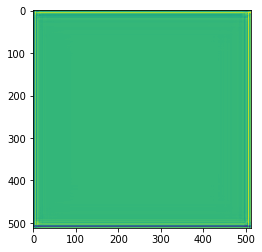

In [37]:
plt.imshow(pred[0, :, :, 0])